In [1]:
import matplotlib.pyplot as plt
import seaborn as sns 
import subprocess
import pandas as pd
import numpy as np

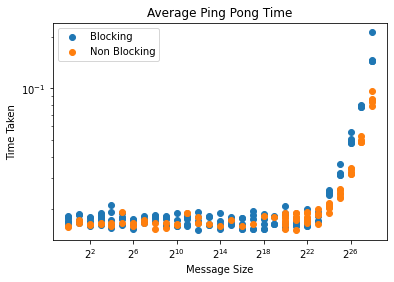

In [6]:
header = ['Processors', 'Message Size', 'Time Taken']
################################################################
#Blocking Data
data_b = pd.read_csv('ping_pong_blocking.csv', header=0)
data_b.columns = header
data_b.head()

processors_b = data_b['Processors']
messageSize_b = data_b['Message Size']
time_b = data_b['Time Taken']
iterations = 100

avgCommunicationTime_b = time_b / iterations

################################################################
#non- blocking Data
data_nb = pd.read_csv('ping_pong_nonblocking.csv', header=0)
data_nb.columns = header
data_nb.head()

processors_nb = data_nb['Processors']
messageSize_nb = data_nb['Message Size']
time_nb = data_nb['Time Taken']
iterations = 100

avgCommunicationTime_nb = time_nb / iterations
################################################################

plt.figure()
plt.scatter(messageSize_b, avgCommunicationTime_b,label = 'Blocking')
plt.scatter(messageSize_nb,avgCommunicationTime_nb,label = 'Non Blocking')
plt.xscale('log', base=2)
plt.yscale('log')
plt.title('Average Ping Pong Time')
plt.xlabel('Message Size')
plt.ylabel('Time Taken')
plt.legend()
plt.show()
